### Урок 8. Снижение размерности данных 

#### 1. Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 4), (30, 4))

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [7]:
def e_metrics(x1, x2):
    
    distance = np.linalg.norm(x1 - x2)

    return distance

Реализуем алгоритм поиска k ближайших соседей.
и добавим веса от расстояния: $w(d) = q^{d}$,   $q \in (0,1)$

In [8]:
def knn(x_train, y_train, x_test, k, q):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            w = q**d[0]
            classes[d[1]] += w

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [9]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма

In [10]:
k, q = 10, 0.9

y_pred = knn(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10, q = 0.9: 0.967


Напишем функцию стандартизации выборки

In [12]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

Для начала отмасштабируем выборку

In [13]:
X = X.astype(float)

X = standard_scale(X)

In [14]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.7746724797993, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021052, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569722, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.1072254642929535, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [15]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329989, 22.850761786701757, 3.668921889282871, 0.5178709107154924]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [16]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [17]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

Разделим полученную выборку на обучающую и тестовую

In [18]:
X_train, X_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

Построим график распределения классов.

In [20]:
def get_graph(X_train, y_train, k, q):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Проверим работу алгоритма с уменьшенным количеством признаков

In [19]:
k, q = 10, 0.9

y_pred = knn(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10, q = 0.9: 0.900


4 признака: Точность алгоритма при k = 10, q = 0.9: 0.967 \
2 признака: Точность алгоритма при k = 10, q = 0.9: 0.900

Потеря в точности незначительна

График распределения классов.

(5913, 2)


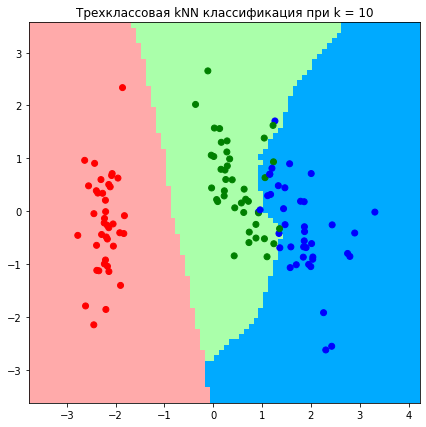

Wall time: 3.77 s


In [21]:
%%time
get_graph(X_train, y_train, k, q)